# Exercise Sheet 5: Electrodes Electronics

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import bci_minitoolbox as bci
from scipy import signal as signal
import Exercise5_helper36 as helper

## Task 1: Parallel circuit & current source (1 point)
Write a function *R_par* implementing the parallel circuit of two resistances.

The circuit can be described by 

$R=\frac{R1 \cdot R2}{R1+R2}$. 

What happens if $R2>>R1$?

Simulate the voltage $U$ produced by a current source with an output resistance of $R_i=100 \Omega$ and a constant current of $I_s=10nA$ connected to a range of loads from $R_L=1\Omega$ to $10k\Omega$. In a current source, the output load $R_L$ is connected in parralel to the internal resistance of the current source $R_i$(see slides):

$U=(R_i // R_L) I_s$


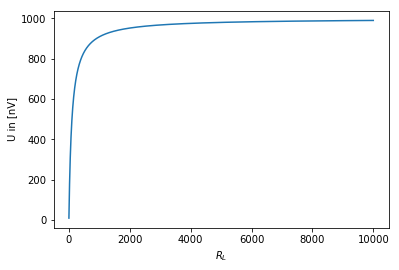

In [2]:
def R_par(r1, r2):
    return (r1*r2)/(r1+r2)

ri = 100
Is = 10
U = []
for rL in range(1, 10000):
    U.append(R_par(ri,rL)*Is) 

plt.plot (U)
plt.xlabel('$R_L$')
plt.ylabel('U in [nV]')
plt.show()

- for $R_L >> R_i$ the voltage is not increasing any more

## Task 2: Common-Mode rejection (2 points)
Common-mode noise in amplification settings is a disturbing potential or current, that is found equally on all measurement channels. This can disturb e.g. the measurements of potential differences between two electrodes in EEG or ECG, because even the best amplifiers can not fully supress it.

For EEG, the signal of interest is in the range of $1 \mu V$ while e.g. the power line noise is in the range of $1..100 mV$. This is a signal to noise ratio (SNR) of -30dB to -50dB, which is pretty poor. Usual EEG amplifiers have a Common-Mode Rejection Ratio (CMMR) of 80dB to 110dB.

**Tasks:**

a) Simulate a simplified alpha wave as a sine of 10Hz on the time interval $[0s .. 1s]$ of $1\mu V$ amplitude on one channel $U_1$ and then the same with different sign on a second channel $U_2=-U_1$. Then add $50Hz$ power line noise as a sine wave on both channels equally with an amplitude of $1mV$.

b) Simulate and plot the output $U_a$ of a differential amplifier with 20,40 and 80dB common-mode rejection ratio by calculating the difference $U_1-U_2$ and then adding the average of both channels attenuated by the common-mode rejection ratio.

In [3]:
# V_out = G*(V_+ -V_-)  + H/2*(V_+ -V_-)   [H stuff has to do with common mode rejection ratio]

f = 10
x = np.arange(0,1,0.001)
u1 = 1 * np.sin(2 * np.pi * f * x)

u2 = -u1
f_noise = 50
noise = 1000 * np.sin(2 * np.pi * f_noise * x)
u1 += noise
u2 += noise

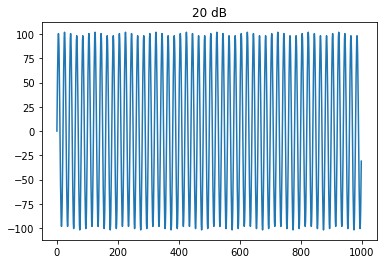

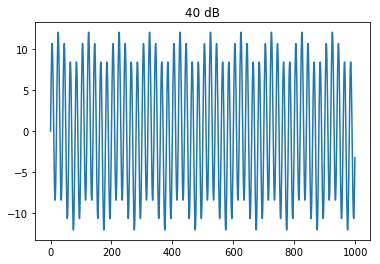

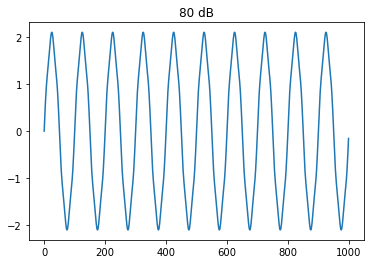

In [4]:
H = 1/(10**(20/20))
Ua = (u1-u2) + H/2*(u1+u2)
plt.plot(Ua)
plt.title('20 dB')
plt.show()

H = 1/(10**(40/20))
Ua = (u1-u2) + H/2*(u1+u2)
plt.plot(Ua)
plt.title('40 dB')
plt.show()

H = 1/(10**(80/20))
Ua = (u1-u2) + H/2*(u1+u2)
plt.title('80 dB')
plt.plot(Ua)
plt.show()

## Task 3: Amplifier input impedance (5 points)
In our headmodel from Exercise Sheet 3, we only inspected the electrical properties within the head and looked at potentials and currents on the different interfaces between the tissues and on the scalp surface where the electrode have contact. To this model we can add the impedances of the measuerement equipment to investigate how they influence the current distributions within the head and thus the potentials on the scalp.

Our headmodel so far was based on the equation:

$Ax=b;\qquad x=\left[
\begin{array}{ccccc}
V_{S_1}\\p_{S_1}\\V_{S_2}\\p_{S_2}\\V_{S_3}\\p_{S_3}\\V_{S_4}
\end{array}
\right]$

where $A$ is the head model matrix, $x$ are the surface currents and potentials and $b$ are the additionally implied inhomogenities or boundary conditions. In Exercise Sheet 4, $b$ was the field of neuronal activity within the head. We can formulate $b$ for all different kinds of applications. The OpenMEEG toolbox is also capable of dealing with currents normal to the surface of the head and so through different connected electrodes. This toolbox functionality is actually supposed to solve Electrical Impedance Tomography (EIT) and trancscanial Current Stiumlation (tCS) applications but can also be used to model the effect of connected measurement hardware. From Clerc et al. 2005 we can take equation (15) and extend it to the 4-shell BEM:

$b_{currents}=\left[
\begin{array}{ccccc}
0\\0\\0\\0\\-D^*_{34}z\\\sigma ^{-1}S_{34}z\\-\frac{j}{2}+D^*_{44}z
\end{array}
\right]=\left[
\begin{array}{ccccc}
0\\0\\0\\0\\-D^*_{34}\\\sigma ^{-1}S_{34}\\-\frac{1}{2}+D^*_{44}
\end{array}
\right]z=
Cz$

The matrix C in our case is the file 'csm.npy' and z is a vector of discretized currents for each electrode (in the original literature z is called j because it is treated continously).

The fact of linearity leads to the possibility of superposition of the eeg boundary conditions $b_{eeg}$ with the surface currents $b_{currents}$. Now we can build a system incorporating the effect of currents through the electrodes:

$Ax=b_{currents}+b_{EEG}=Cz+b_{EEG}$

where $z$ is the discretized current for each electrode. If we incorporate the feedback through the electrodes by a simple star circuit to ground for all channels with equal input impedance $R_{input}$ and include the interpolation $W$ of $v$ from the state variables $x$, we can write $z=\frac{1}{R_{input}}v=\frac{1}{R_{input}}Wx$ and transform the equation to include it into the model:

$Ax=Cz+b_{EEG}=C\frac{1}{R_{input}}Wx+b_{EEG}$

which can be rephrased to: 

$\left(A-\frac{1}{R_{input}}CW\right)x=b_{EEG}$

we can define a new system matrix $A_{new}=\left(A-\frac{1}{R_{input}}CW\right)$ to get a new model incorporating the amplifiers input impedance:

$x=A_{new}^{-1}b_{EEG}$

and the corresponding scalp potentials:

$v=Wx=WA_{new}^{-1}b_{EEG}$

This model does simplify the input impedance a little but works for illustrative purposes.

**Tasks:**

Common values for modern EEG amplifiers for the input impedance lie in the range of $R_{input}=100M\Omega$, however $1M\Omega$ is enough for our modeling purposes.

Model the effect of a single neuronal source (same as Exercise Sheet 3 - Task 8) by incorporating the new $A_{new}$ into the leadfield $L=WA^{-1}_{new}c$ in $v=Ls$:

a) for an equal amplifier input impedance of $R_{input}=1M\Omega$

b) for an equal amplifier input impedance of $R_{input}=1K\Omega$

c) for an equal amplifier input impedance of $R_{input}=100\Omega$
 
What happens to the scalp potential for the different input impedance values?

*Hint: If you run into memory issues calculating the inverses of the matrices A_inv and A_new, you can donwload the computed versions of $L'=A_{new}^{-1}\cdot dsm[:,iDip]$ as 'L**.npy' for a),b) and c) from the ISIS page. iDip is here 2499. If you use them, make sure to have the correct formulas to produce them in you source code*
- if we use this, then we do not need the 2.7GB Ainv matrices as the next step is already done in L**.npy

In [5]:
h2em=np.load('h2em.npy')
hminv=np.matrix(np.load('hminv.npy'))
dsm=np.load('dsm.npy')
csm=np.load('csm.npy')
no_chan=h2em.shape[0]

iDip=2499
p=np.array([0,0,1])

#For memory & computation reasons we reduce dsm to the one of a single dipole before the operations
b_eeg=np.dot(dsm[:,iDip],p)

#Here again the scalpmap function exemplarily to show how to plot the potential:
mnt=np.load('mnt.npy')
clab=np.load('clab.npy')



FileNotFoundError: [Errno 2] No such file or directory: 'h2em.npy'

In [6]:
#a_new_1m = hminv.I - (1 / 1e6) * csm.dot(h2em)
#a_inv_1m = a_new_1m.I
a_inv_1m = np.load('Ainv1M.npy')
x_1m = a_inv_1m.dot(b_eeg)
l1M = h2em.dot(x_1m.T)

plt.figure()
bci.scalpmap(mnt, l1M, clim='sym', cb_label='potential  [V]')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Ainv1M.npy'

In [7]:
# a_new_1k = hminv.I - (1 / 1000) * csm.dot(h2em)
# a_inv_1k = a_new_1k.I
a_inv_1K = np.load('Ainv1K.npy')
x_1k = a_inv_1K.dot(b_eeg)
l1K = h2em.dot(x_1k.T)

plt.figure()
bci.scalpmap(mnt, l1K, clim='sym', cb_label='potential  [V]')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Ainv1K.npy'

(72,)


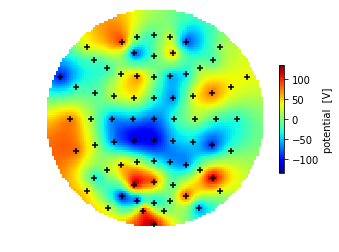

In [93]:
# a_new_100 = hminv.I - (1 / 100) * csm.dot(h2em)
# a_inv_100 = a_new_100.I
a_inv_100 = np.load('Ainv100.npy')
x_100 = a_inv_100.dot(b_eeg)
l100 = h2em.dot(x_100.T)

plt.figure()
bci.scalpmap(mnt, l100, clim='sym', cb_label='potential  [V]')
plt.show()

## Task 4: noise & signal models (4 points)
Simulate and plot noise & a simple alpha-oscillation model on a timescale of $5s$ with a sampling frequency of $1kHz$.

a) Generate a function *noise_w* that implements gaussian white noise with the variance $\sigma_n$ as an input parameter. White noise can be simply generated using np.random function and the gaussian one would use the np.random.normal or np.random.randn.

b) Use the white noise function to produce pink noise (1/f) *noise_p* by frequency filtering it in the spectral domain. Therefor do a fourier transformation (np.fft.rfft) of the white noise, get the corresponding frequencies (np.fft.rfftfreq) and then multiply the fourier transfromed signal by $\frac{1}{f^{0.5}}$ (the factor $\frac{1}{f}$ is defined in the power spectrum which leads to $\sqrt{\frac{1}{f}}=\frac{1}{f^{0.5}}$ in the amplitude spectrum). As the DC part ($f=0$) would lead to a division by zero, you can simply divide the coresponding fft value by 1 instead.
Then transform the signal back to time domain (np.fft.irfft).

c) Do the same as for the pink noise to generate a simulated alpha oscillation *x_alpha* by tranformation of white noise to the frequency domain, spectral filtering and then transformation back to the time domain. For the shape in the frequency domain, use a peak function similar to that found in EEG.  A gaussian peak from 8 to 13 Hz with a standard deviation of $\frac{1}{10}$ of it's window (8-13Hz) with and the function *scipy.signal.gaussian(N,std)* as an approximation to the peak of an alpha oscillation in the frequency spectrum or similar is sufficient.

Plot all three noise & signal models into one plot first in the time domain and then in a secon plot in the frequency domain.

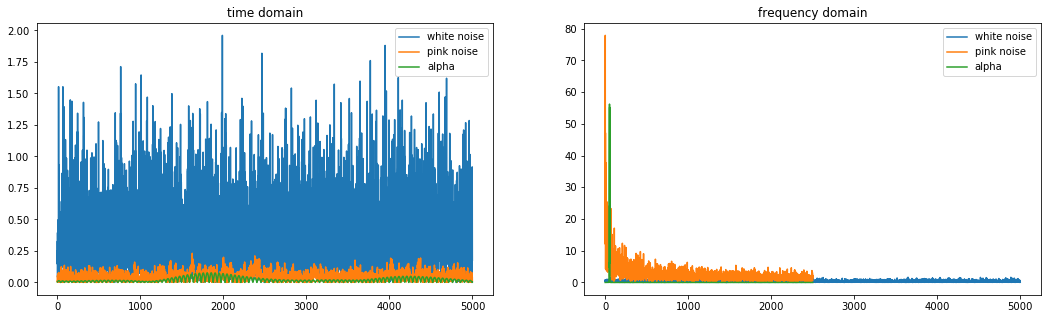

In [8]:
#Alpha waves are neural oscillations in the frequency range of 7.5–12.5 Hz
t = np.linspace(0,5,5000)
sr = 1000
s = 0.5
l = 5000

#(a)
def noise_w(sigma,size): 
    white = np.random.normal(0.0,sigma,size)  
    return white

# (b)
n = noise_w(s,l)
t = np.fft.rfft(n)
frq = np.fft.rfftfreq(n.size,d=1./sr)
frq[0]=1
noise_p_frq = t / np.power(frq,0.5)
noise_p = np.fft.irfft(noise_p_frq)

# (c)
c = []
ind = []
for i,f in enumerate(frq):
    if (f >8)&(f<13):
        c.append(f)
        ind.append(i)
g = np.zeros(frq.shape)
g[ind] = signal.gaussian(len(c),len(c)*1/10)  
alpha_frq = g*np.fft.rfft(n)
x_alpha = np.fft.irfft(alpha_frq)


fig,ax = plt.subplots(1,2,figsize=(18,5))
ax[0].set_title('time domain')
ax[0].plot(np.abs(noise_w(s,l)),label = 'white noise')
ax[0].plot(np.abs(noise_p),label = 'pink noise')
ax[0].plot(np.abs(x_alpha),label = 'alpha')
ax[0].legend()

ax[1].set_title('frequency domain')
ax[1].plot(np.abs(noise_w(s, l)),label = 'white noise')
ax[1].plot(np.abs(noise_p_frq) ,label = 'pink noise')
ax[1].plot(np.abs(alpha_frq),label = 'alpha')
ax[1].legend()
plt.show()

## Task 5 EEG simulation (3 points)

a) Generate a signal 

$v(t)=\alpha_x x(t)+\alpha_w n_w(t)+\alpha_p n_p(t)$, 

where $x(t)$ is the simulation an alpha osicllation *x_alpha*, $w_n$ is white noise and $p_n$ is pink noise. The $\alpha$s are the corresponding weights to account for individual signal powers. Plot the time course for a single channel of length $5s$ with a sampling frequency of 1kHz. Do a frequency transformation using the fourier transform and plot the power spectrum. Tune your weights $\alpha$ to get a roughly EEG-like spectrum.

b) Use the leadfield of one dipole of your choice (without amplifier input impedance) and simulate the scalp potential $v$ of an alpha oscillation in that source *s* by multiplying it with the leadfield $x(t)=L\cdot s(t)$. You can also load the scalp pattern produced by dipole 2081 in $p=[0, \sqrt[]2/3, \sqrt[]1/3 ]^T$ saved in 'patternDip2081.npy' to avoid the calculations. Plot the time course for channels Cz and Oz into one plot. Also, plot the power spectrum for the two channels.

c) Repeat task a) but this time use the scalp potential $x(t)$ produced in b) to simulate an EEG. Add the noise independently to each channel allthough this is not fully realistic.

$v(t)=x(t)+\alpha_w n_w(t)+\alpha_p n_p(t)$

Again, plot the time course and the power spectrum for channels Cz and Oz.

d) Use the scalpmap function of the BBCI minitoolbox to plot the scalp pattern of the 10 Hz component in the fourier transform of the signal of task c) and compare it to the plain scalp pattern of that source.

*Hint: You can use the exercise5_helper if you haven't succeeded with task 4!*

/home/lukas/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


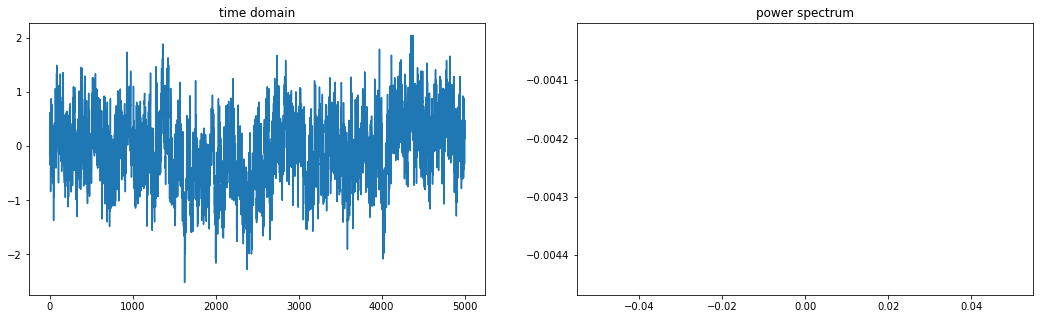

In [9]:
a_x = 0.3
a_w = 0.1
a_p = 10
# (a)
v = a_x*x_alpha + a_w*n + a_p*noise_p
xf=np.fft.rfft(v) #this is according to the discussion forum, how to decompose power spectral 
f_v = np.fft.rfftfreq(v.size,d=1./sr)


fig,ax = plt.subplots(1,2,figsize=(18,5))
ax[0].set_title('time domain')
ax[0].plot(np.ravel(v))

ax[1].set_title('power spectrum')
# ax[1].plot(1/f_v[1:500])
ax[1].plot(1/xf[0])


plt.show()

In [10]:
p = np.load('patternDip2081.npy')
clab=np.load('clab.npy')
mnt=np.load('mnt.npy')

for i in range(len(clab[0])):
    if clab[0][i] == 'Cz':
        cz = i
    elif clab[0][i] == 'Oz':
        oz = i
        
x_alpha = np.reshape(x_alpha, (1, 5000))
x_t = p.dot(x_alpha)
xf=np.fft.rfft(x_t) #this is according to the discussion forum, how to decompose power spectral 

fig,ax = plt.subplots(1,2,figsize=(18,5))
ax[0].set_title('time domain')
ax[0].plot(x_t[oz], label="oz")
ax[0].plot(x_t[cz], label="cz")
ax[0].legend()

ax[1].set_title('power spectrum')
# ax[1].plot(1/f_v[1:500])
ax[1].plot(1/xf[cz], label="cz")
ax[1].plot(1/xf[oz], label="oz")
ax[1].legend()


plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'mnt.npy'

/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


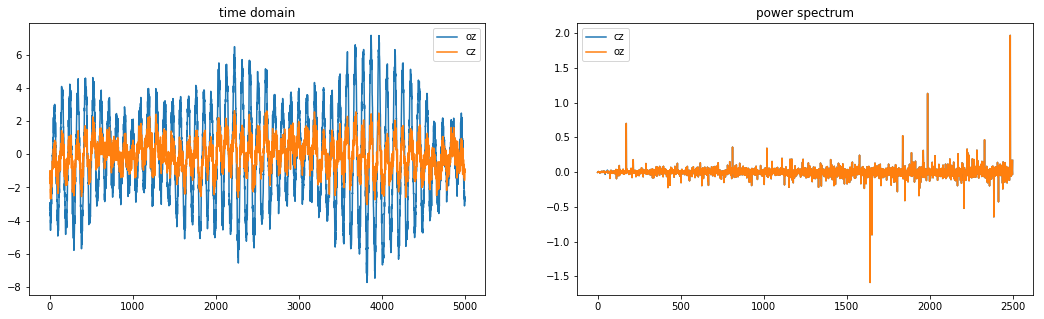

In [89]:
v_scalp_potential_cz = x_t[cz] + a_w*n + a_p*noise_p
xf_cz = np.fft.rfft(v_scalp_potential_cz)

v_scalp_potential_oz = x_t[oz] + a_w*n + a_p*noise_p
xf_oz = np.fft.rfft(v_scalp_potential_oz)



fig,ax = plt.subplots(1,2,figsize=(18,5))
ax[0].set_title('time domain')
ax[0].plot(v_scalp_potential_oz, label="oz")
ax[0].plot(v_scalp_potential_cz, label="cz")
ax[0].legend()

ax[1].set_title('power spectrum')
# ax[1].plot(1/f_v[1:500])
ax[1].plot(1/xf_cz, label='cz')
ax[1].plot(1/xf_oz, label='oz')
ax[1].legend()

plt.show()


#need power specturm which I don't know what it means. 

In [84]:
print(xf_cz)
print(xf_oz)

[-193.2786952   +0.j         -539.7386789 -141.55364997j
  -95.67991291-494.0036836j  ...   23.25170639 -21.4029829j
  -17.95665352 -12.26764967j    5.94488348  +0.j        ]
[-193.2786952   +0.j         -539.7386789 -141.55364997j
  -95.67991291-494.0036836j  ...   23.25170639 -21.4029829j
  -17.95665352 -12.26764967j    5.94488348  +0.j        ]
